In [1]:
# Imports
import os, gc
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from testing_functions import test_hss
from process_functions import preprocessing_audio
from utils import find_and_open_audio, signal_segmentation, get_resp_segments
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, \
    upsampling_signal
from source_separation.descriptor_functions import get_spectrogram
from IPython.display import Audio
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing, svm

In [2]:
# Dirección de la base de datos
db_folder = 'Interest_sounds'

# Definición de los síntomas a revisar
symptoms = ('Bronchiectasis', 'Bronchiolitis', 'Healthy', 'LRTI',
            'Pneumonia', 'URTI')

# Definición de la frecuencia de muestreo deseada para 
# separación de fuentes
samplerate_nmf = 11025 # Hz
samplerate_cls = 4000  # Hz

In [3]:
# Cargando datos
data = np.load(f'_temp_files/diseases_preprocessed_nmfcc{13}max.npz')
X_data = data['X_data']
Y_data = data['Y_data']

# Preprocesamiento

In [10]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [25]:
# Parámetros utilizados para el preprocesamiento
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}       # None
model_name = 'definitive_segnet_based'

# Definición de los parámetros NMF
nmf_method = 'replace_segments'
N = 1024
nmf_parameters = {'n_components': 10, 'N': N, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * N), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

# Parámetros de los descriptores
n_mfcc = 40
N = 1024
noverlap = int(0.75 * N)
window = 'hann'

# Sobre la señal completa

In [26]:
%matplotlib notebook

# Definición de los arrays donde se acumulará las características
X_data = list()
# Definición de los arrays donde se acumularán las etiquetas
Y_wheeze = list()
Y_crackl = list()

# Parámetros
preprocess = False
# Decisión de características
mfcc_bool = True
psd_bool = False


# Método de colapso
collapse_mfcc = 'max'


# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}')
    print(f'-------------')
    
    filename = f'{db_folder}/{name}'

    # Cargando el archivo
    try:
        samplerate, audio = wavfile.read(f'{filename}.wav')
    except:
        audio, samplerate = sf.read(f'{filename}.wav')
    
    
    # Normalizando
    audio = audio / max(abs(audio))
    
    if preprocess:
        if samplerate == 44100:
            # Aplicando preprocesamiento
            resp_signal, heart_signal = \
                    preprocessing_audio(audio, samplerate, model_name, lowpass_params,
                                        nmf_parameters, nmf_method=nmf_method,
                                        filter_parameters={'bool': False},
                                        plot_segmentation=False,
                                        plot_separation=False)

            # Aplicando downsampling a 4000 Hz
            if samplerate == 44100:
                resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate)
                resp_to, _ = _conditioning_signal(resp_to, samplerate, samplerate_cls)
            else:
                continue
                resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate_cls)
        
        else:
            continue
        
    else:
        resp_to, _ = _conditioning_signal(audio, samplerate, samplerate_cls)
    
    
    # Obteniendo la información de los segmentos de este archivo de audio
    resp_list_info = get_resp_segments(resp_to, samplerate_cls, 
                                       filepath=f'{filename}.txt')
    
    print(resp_to.shape, audio.shape)
    
    # Para cada segmento, se obtiene la información de interés
    for resp_info in resp_list_info[:-1]:
        # Definición de la lista de características a agregar
        features_to_append = list()
        
        # Calculando las características a partir del segmento
        if mfcc_bool:
            mfcc = librosa.feature.mfcc(y=resp_info[0], sr=samplerate_cls, n_mfcc=n_mfcc)

            # Resumiendo
            if collapse_mfcc == 'mean':
                mfcc_collapsed = mfcc.mean(axis=1)
            elif collapse_mfcc == 'max':
                mfcc_collapsed = mfcc.max(axis=1)
            
            # Agregando a la lista de características
            features_to_append.extend(mfcc_collapsed)
        
        if psd_bool:
            _, psd_to = signal.welch(x=resp_info[0], fs=samplerate_cls, window=window, 
                                     nperseg=N, noverlap=noverlap, nfft=N)
            
            # Agregando a la lista de características
            features_to_append.extend(psd_to)
        
        # Agregando la información a cada arreglo
        X_data.append(features_to_append)
        Y_wheeze.append(resp_info[1])
        Y_crackl.append(resp_info[2])
        
        
#         # Espectrogrma
#         plt.figure()
#         plt.subplot(1,2,1)
#         plt.plot(resp_info[0])

#         t, f, S = get_spectrogram(resp_info[0], samplerate_cls, N=1024, 
#                                   padding=1024, repeat=0, noverlap=768, 
#                                   window='hann', whole=False)

#         plt.subplot(1,2,2)
#         plt.pcolormesh(t, f, 20 * np.log10(abs(S)), cmap='jet')
#         plt.show()
        


# Transformando listas a arrays
X_data = np.array(X_data)
Y_wheeze = np.array(Y_wheeze)
Y_crackl = np.array(Y_crackl)

Iteración 1: Síntoma Bronchiectasis - 116_1b2_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 2: Síntoma Bronchiectasis - 168_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 3: Síntoma Bronchiectasis - 169_1b1_Lr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 4: Síntoma Bronchiectasis - 169_1b2_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 5: Síntoma Bronchiectasis - 196_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 6: Síntoma Bronchiectasis - 201_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 7: Síntoma Bronchiectasis - 201_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 8: Síntoma Bronchiectasis - 201_1b2_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Iteración 9: Síntoma Bronchiectasis - 201_1b2_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Iteración 10: Síntoma Bronchiectasis - 20

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 12: Síntoma Bronchiectasis - 215_1b2_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 1: Síntoma Bronchiolitis - 149_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 2: Síntoma Bronchiolitis - 149_1b1_Lr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 3: Síntoma Bronchiolitis - 149_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 4: Síntoma Bronchiolitis - 161_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 5: Síntoma Bronchiolitis - 161_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 6: Síntoma Bronchiolitis - 167_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 7: Síntoma Bronchiolitis - 167_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 8: Síntoma Bronchiolitis - 173_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 9: Síntoma Bronchiolitis - 206_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 10: Síntoma Bronchiolitis - 206_1b1_Lr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 11: Síntoma Bronchiolitis - 206_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 12: Síntoma Bronchiolitis - 216_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 13: Síntoma Bronchiolitis - 216_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 1: Síntoma Healthy - 102_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Iteración 2: Síntoma Healthy - 123_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 3: Síntoma Healthy - 126_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 4: Síntoma Healthy - 127_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 5: Síntoma Healthy - 136_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 6: Síntoma Healthy - 143_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 7: Síntoma Healthy - 144_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 8: Síntoma Healthy - 152_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 9: Síntoma Healthy - 153_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 10: Síntoma Healthy - 159_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 11: Síntoma Healthy - 159_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 12: Síntoma Healthy - 159_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 13: Síntoma Healthy - 159_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 14: Síntoma Healthy - 171_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 15: Síntoma Healthy - 179_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 16: Síntoma Healthy - 183_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 17: Síntoma Healthy - 184_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 18: Síntoma Healthy - 187_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 19: Síntoma Healthy - 194_1b1_Lr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Iteración 20: Síntoma Healthy - 194_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 21: Síntoma Healthy - 202_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 22: Síntoma Healthy - 208_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 23: Síntoma Healthy - 214_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 9ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 24: Síntoma Healthy - 224_1b2_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 25: Síntoma Healthy - 225_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 1: Síntoma LRTI - 108_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 2: Síntoma LRTI - 115_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 1: Síntoma Pneumonia - 122_2b1_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 2: Síntoma Pneumonia - 122_2b1_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 3: Síntoma Pneumonia - 122_2b2_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 4: Síntoma Pneumonia - 122_2b2_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 5: Síntoma Pneumonia - 122_2b3_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 6: Síntoma Pneumonia - 122_2b3_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 7: Síntoma Pneumonia - 135_2b1_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 8: Síntoma Pneumonia - 135_2b1_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 9: Síntoma Pneumonia - 135_2b1_Pl_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 10: Síntoma Pneumonia - 135_2b2_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 11: Síntoma Pneumonia - 135_2b2_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 12: Síntoma Pneumonia - 135_2b2_Pl_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 13: Síntoma Pneumonia - 135_2b3_Al_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 14: Síntoma Pneumonia - 135_2b3_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 15: Síntoma Pneumonia - 135_2b3_Pl_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 16: Síntoma Pneumonia - 135_2b3_Pr_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Iteración 17: Síntoma Pneumonia - 140_2b2_Ll_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 18: Síntoma Pneumonia - 140_2b3_Ll_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 19: Síntoma Pneumonia - 191_2b1_Pl_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 20: Síntoma Pneumonia - 191_2b1_Pr_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 21: Síntoma Pneumonia - 219_2b1_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 22: Síntoma Pneumonia - 219_2b2_Ar_mc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 23: Síntoma Pneumonia - 226_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 24: Síntoma Pneumonia - 226_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 25: Síntoma Pneumonia - 226_1b1_Pl_sc_LittC2SE
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Iteración 1: Síntoma URTI - 101_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 2: Síntoma URTI - 101_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 3: Síntoma URTI - 119_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 4: Síntoma URTI - 129_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 5: Síntoma URTI - 131_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 6: Síntoma URTI - 137_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 7: Síntoma URTI - 137_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 8: Síntoma URTI - 148_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 9: Síntoma URTI - 150_1b2_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 10: Síntoma URTI - 164_1b1_Ll_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 11: Síntoma URTI - 165_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 12: Síntoma URTI - 165_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 13: Síntoma URTI - 165_1b1_Pr_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 14: Síntoma URTI - 188_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 15: Síntoma URTI - 188_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 16: Síntoma URTI - 188_1b1_Pl_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 17: Síntoma URTI - 197_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 18: Síntoma URTI - 210_1b1_Al_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Iteración 19: Síntoma URTI - 210_1b1_Ar_sc_Meditron
--------------------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada


# Guardando datos en un archivo .npz

In [27]:
np.savez(f'_temp_files/diseases_preprocessed_nmfcc{n_mfcc}max.npz', X_data=X_data, Y_data=Y_data)

# Normalizando

In [3]:
scaler = preprocessing.StandardScaler()
X_data_norm = scaler.fit_transform(X_data)

In [4]:
# Colores
colors = ('red', 'blue', 'cyan', 'magenta', 'limegreen', 'orange')
markers = ('o', 'x', '^', '*', '+', 'D')

# Definición de los síntomas a diagnósticar
to_symptom = ['Healthy', 'Pneumonia']

# Testeando SFS

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), U

<IPython.core.display.Javascript object>


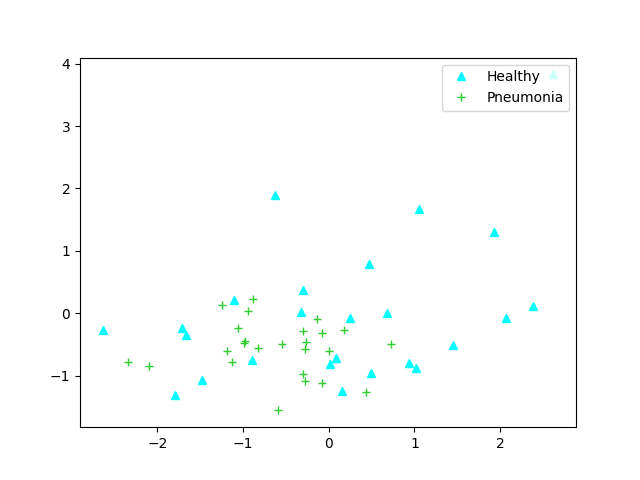

In [7]:
knn = KNeighborsClassifier(n_neighbors=3)
svm_ = svm.SVC(kernel='sigmoid', degree=50, gamma='auto')
sfs = SequentialFeatureSelector(knn, n_features_to_select=2)

X_new = sfs.fit_transform(X_data_norm, Y_data)

%matplotlib notebook
for class_i in np.unique(Y_data):
    if not symptoms[class_i] in to_symptom:
        continue
    
    # Definición de los puntos de una clase en particular
    X_class_i = X_new[np.where(Y_data == class_i)]
    
    # Graficando en 2D
    plt.plot(X_class_i[:, 0], X_class_i[:, 1], color=colors[class_i], 
             marker=markers[class_i], linestyle=' ', label=symptoms[class_i])

plt.legend(loc='upper right')
plt.show()

# Testeando PCA

<IPython.core.display.Javascript object>


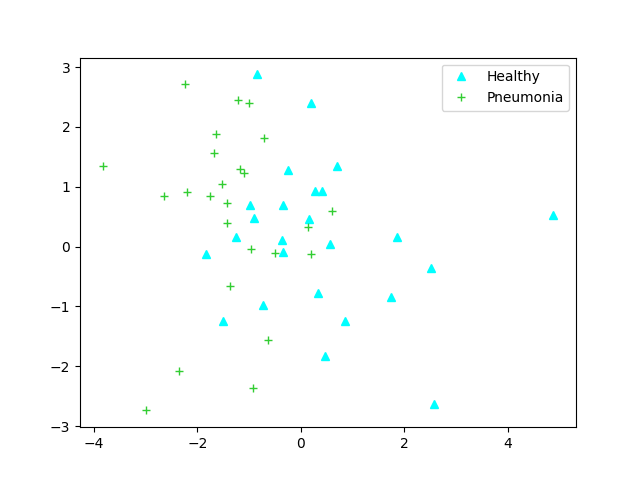

In [8]:
pca = PCA(n_components=10, random_state=0)
X_new = pca.fit_transform(X_data_norm)

%matplotlib notebook
for class_i in np.unique(Y_data):
    if not symptoms[class_i] in to_symptom:
        continue
    
    # Definición de los puntos de una clase en particular
    X_class_i = X_new[np.where(Y_data == class_i)]
    
    # Graficando en 2D
    plt.plot(X_class_i[:, 0], X_class_i[:, 1], color=colors[class_i], 
             marker=markers[class_i], linestyle=' ', label=symptoms[class_i])

plt.legend(loc='upper right')
plt.show()

# Solo preprocesando las señales de interés

In [2]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [3]:
# Dirección de la base de datos
db_folder = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

In [4]:
# Parámetros utilizados para el preprocesamiento
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}       # None
model_name = 'definitive_segnet_based'

# Definición de los parámetros NMF
nmf_method = 'replace_segments'
N = 1024
nmf_parameters = {'n_components': 10, 'N': N, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * N), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

# Parámetros de los descriptores
n_mfcc = 40
N = 1024
noverlap = int(0.75 * N)
window = 'hann'

In [ ]:
%matplotlib notebook

# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}')
    print(f'-------------')
    
    filename = f'{db_folder}/{name}'

    # Cargando el archivo
    try:
        samplerate, audio = wavfile.read(f'{filename}.wav')
    except:
        audio, samplerate = sf.read(f'{filename}.wav')
    
    
    # Normalizando
    audio = audio / max(abs(audio))
    
    if samplerate == 44100:
        # Definición de la frecuencia de muestreo deseada para 
        # separación de fuentes
        samplerate_nmf = 11025 # Hz
        samplerate_cls = 4410  # Hz

        # Aplicando preprocesamiento
        resp_signal, heart_signal = \
                preprocessing_audio(audio, samplerate, samplerate_nmf,
                                    model_name=model_name, 
                                    lowpass_params=lowpass_params,
                                    nmf_parameters=nmf_parameters, 
                                    nmf_method=nmf_method,
                                    filter_parameters={'bool': False},
                                    plot_segmentation=False,
                                    plot_separation=False)

        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate)
        resp_to, _ = _conditioning_signal(resp_to, samplerate, samplerate_cls)
        
        sf.write(f'preprocessed_signals/{name}_44100.wav', resp_to, samplerate_cls)
    
    
    elif samplerate == 4000:
        # Definición de la frecuencia de muestreo deseada para 
        # separación de fuentes
        samplerate_nmf = 12000 # Hz
        samplerate_cls = 4000  # Hz
        
        # Aplicando preprocesamiento
        resp_signal, heart_signal = \
                preprocessing_audio(audio, samplerate, samplerate_nmf,
                                    model_name=model_name, 
                                    lowpass_params=lowpass_params,
                                    nmf_parameters=nmf_parameters, 
                                    nmf_method=nmf_method,
                                    filter_parameters={'bool': False},
                                    plot_segmentation=False,
                                    plot_separation=False)

        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, samplerate_cls)
        
        sf.write(f'preprocessed_signals/{name}_4000.wav', resp_to, samplerate_cls)
    
    
    elif samplerate == 10000:
        # Definición de la frecuencia de muestreo deseada para 
        # separación de fuentes
        samplerate_nmf = 10000 # Hz
        samplerate_cls = 4000  # Hz
        
        # Aplicando preprocesamiento
        resp_signal, heart_signal = \
                preprocessing_audio(audio, samplerate, samplerate_nmf,
                                    model_name=model_name, 
                                    lowpass_params=lowpass_params,
                                    nmf_parameters=nmf_parameters, 
                                    nmf_method=nmf_method,
                                    filter_parameters={'bool': False},
                                    plot_segmentation=False,
                                    plot_separation=False)

        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(resp_signal, samplerate_nmf, 40000)
        resp_to, _ = _conditioning_signal(resp_to, 40000, samplerate_cls)
        
        sf.write(f'preprocessed_signals/{name}_10000.wav', resp_to, samplerate_cls)
    
    
    # Eliminando las variables registradas que no se referencian en memoria
    print("Recolectando registros de memoria sin uso...")
    n = gc.collect()
    print("Número de objetos inalcanzables recolectados por el GC:", n)
    print("Basura incoleccionable:", gc.garbage)

Iteración 1
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65291
Basura incoleccionable: []
Iteración 2
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65200
Basura incoleccionable: []
Iteración 3
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondiciona

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 53501
Basura incoleccionable: []
Iteración 6
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 2ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 80851
Basura incoleccionable: []
Iteración 7
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 60981
Basura incoleccionable: []
Iteración 8
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 51103
Basura incoleccionable: []
Iteración 9
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 73581
Basura incoleccionable: []
Iteración 10
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 75741
Basura incoleccionable: []
Iteración 11
-------------
Downsampling de la señal de fs = 441

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 13
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 14
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 15
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 2ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 16
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 17
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 18
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 2ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 19
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 20
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 2ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 21
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 22
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 23
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 24
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 25
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 26
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 27
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 28
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 29
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 30
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 2ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 31
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 32
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 33
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 34
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 35
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 36
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 37
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 38
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables r

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65087
Basura incoleccionable: []
Iteración 40
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 56627
Basura incoleccionable: []
Iteración 41
-------------
Upsampling de la señal de fs = 4000 

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 58079
Basura incoleccionable: []
Iteración 42
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 58587
Basura incoleccionable: []
Iteración 43
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 93236
Basura incoleccionable: []
Iteración 44
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 209822
Basura incoleccionable: []
Iteración 45
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 99703
Basura incoleccionable: []
Iteración 46
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 100107
Basura incoleccionable: []
Iteración 47
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 100107
Basura incoleccionable: []
Iteración 48
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 220582
Basura incoleccionable: []
Iteración 49
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 199808
Basura incoleccionable: []
Iteración 50
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 103436
Basura incoleccionable: []
Iteración 51
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 91515
Basura incoleccionable: []
Iteración 52
-------------
Upsampling de la señal de fs = 4000

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 93236
Basura incoleccionable: []
Iteración 53
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 93236
Basura incoleccionable: []
Iteración 54
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 49864
Basura incoleccionable: []
Iteración 55
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 53217
Basura incoleccionable: []
Iteración 56
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 67538
Basura incoleccionable: []
Iteración 57
-------------
Upsampling de la señal de fs = 4000 

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 70667
Basura incoleccionable: []
Iteración 60
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 61
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicion

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 64
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 65
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 66
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 67
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 52521
Basura incoleccionable: []
Iteración 68
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 60512
Basura incoleccionable: []
Iteración 69
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 44083
Basura incoleccionable: []
Iteración 70
-------------
Upsampling de la señal de fs = 4000 

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65357
Basura incoleccionable: []
Iteración 71
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 44021
Basura incoleccionable: []
Iteración 72
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 44021
Basura incoleccionable: []
Iteración 73
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 74
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables r

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 196609
Basura incoleccionable: []
Iteración 76
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 251367
Basura incoleccionable: []
Iteración 77
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 198409
Basura incoleccionable: []
Iteración 78
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 198409
Basura incoleccionable: []
Iteración 79
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 80
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 81
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 82
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 83
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 84
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 85
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 86
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 44083
Basura incoleccionable: []
Iteración 87
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 40621
Basura incoleccionable: []
Iteración 88
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 60263
Basura incoleccionable: []
Iteración 89
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 57403
Basura incoleccionable: []
Iteración 90
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 35824
Basura incoleccionable: []
Iteración 91
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 30964
Basura incoleccionable: []
Iteración 92
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 93
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65143
Basura incoleccionable: []
Iteración 94
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 95
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 96
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 97
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 98
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 99
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 100
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 101
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 102
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 103
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 104
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 105
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 106
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 107
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 108
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 109
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 110
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 111
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 112
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 113
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 114
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 115
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 116
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 117
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 118
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 119
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 120
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 121
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 122
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 123
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 124
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 125
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 126
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 127
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 128
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 129
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 130
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 131
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 132
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 133
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 134
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 135
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 136
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 137
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 138
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 139
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 140
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 141
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 142
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 143
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 144
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 145
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 146
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 147
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 148
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 149
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 150
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 151
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 152
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 153
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 154
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 155
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 156
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 157
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 158
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 159
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 160
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 161
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 162
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 163
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 164
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 3ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 165
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 166
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 167
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 168
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 169
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 170
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 171
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 172
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 175
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 176
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 177
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 178
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 179
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 180
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 181
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 182
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 183
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 184
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 185
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 186
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 187
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 188
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 189
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 190
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 191
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 192
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 193
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 194
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 195
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 196
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 197
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 198
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 199
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 200
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 201
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 202
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 203
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 204
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 205
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 206
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 207
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 208
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 209
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 210
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 211
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 64155
Basura incoleccionable: []
Iteración 212
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 56627
Basura incoleccionable: []
Iteración 213
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 67538
Basura incoleccionable: []
Iteración 214
-------------
Upsampling de la señal de fs = 400

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 49864
Basura incoleccionable: []
Iteración 216
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 54681
Basura incoleccionable: []
Iteración 217
-------------
Downsampling de la señal de fs = 4

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 218
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 219
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 222
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 224
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 225
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 227
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 228
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65143
Basura incoleccionable: []
Iteración 229
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 230
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 231
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 232
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 233
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 234
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 235
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 236
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 237
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 238
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 239
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 240
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 241
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 242
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 243
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 244
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 245
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 246
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 248
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 249
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 250
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 251
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 252
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 254
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 255
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 256
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 257
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 258
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 259
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 260
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 261
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 262
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 263
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 264
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 265
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 266
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 267
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 269
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 271
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 272
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 273
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 276
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 277
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 278
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 279
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 283
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 284
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 285
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 287
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 288
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 289
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 290
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 291
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 292
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 294
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 295
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 296
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 297
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 298
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 299
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 300
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 301
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 302
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 303
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 304
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 305
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 306
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 307
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 308
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 309
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 310
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 311
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 312
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 313
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 314
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 315
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 316
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 317
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 318
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 319
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 320
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 321
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 323
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 324
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 325
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 326
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 327
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 328
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 329
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 330
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables 

C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\heart_sound_segmentation\envelope_functions.py:409: RuntimeWarning: divide by zero encountered in log
  yaxis = np.concatenate((yaxis, [np.log(var_dx_k)]))
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\heart_sound_segmentation\envelope_functions.py:965: RuntimeWarning: invalid value encountered in true_divide
  return x / max(abs(x))


1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 191897
Basura incoleccionable: []
Iteración 332
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 195956
Basura incoleccionable: []
Iteración 333
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 186443
Basura incoleccionable: []
Iteración 334
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 186443
Basura incoleccionable: []
Iteración 335
-------------
Downsampling de la señal de fs =

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 336
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 337
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 338
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 339
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 340
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 341
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 342
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 343
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 344
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 345
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 346
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 347
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 348
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 349
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 350
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 351
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 352
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 353
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 355
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 356
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 357
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 358
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 359
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 360
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 361
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 362
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 363
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 364
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 365
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 366
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 367
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 368
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 369
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 370
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 371
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 372
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 373
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 374
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 375
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 377
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 378
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 379
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 380
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 381
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 382
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 383
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 384
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 385
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 386
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 387
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 388
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 389
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 390
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 391
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 392
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 393
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 394
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 395
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 396
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 397
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 399
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 400
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 401
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 402
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 403
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 404
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 405
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 406
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 407
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 408
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 409
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 412
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 413
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 64796
Basura incoleccionable: []
Iteración 414
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 415
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 416
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\heart_sound_segmentation\envelope_functions.py:409: RuntimeWarning: divide by zero encountered in log
  yaxis = np.concatenate((yaxis, [np.log(var_dx_k)]))
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\heart_sound_segmentation\envelope_functions.py:965: RuntimeWarning: invalid value encountered in true_divide
  return x / max(abs(x))


1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 183462
Basura incoleccionable: []
Iteración 417
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 183462
Basura incoleccionable: []
Iteración 418
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 171506
Basura incoleccionable: []
Iteración 419
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 184706
Basura incoleccionable: []
Iteración 420
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 184706
Basura incoleccionable: []
Iteración 421
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 422
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 423
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 424
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 425
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 426
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 427
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 428
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 429
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 430
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 431
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 432
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 433
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 434
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 435
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 437
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 438
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 439
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 440
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 442
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 443
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 444
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 445
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 446
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 447
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 448
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 449
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 450
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 451
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 452
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 453
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 454
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 458
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 460
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 4ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 461
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 462
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 9ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 463
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 464
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 465
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 466
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 467
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 468
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 469
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 470
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 471
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 472
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 473
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 475
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 476
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 477
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 478
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 479
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 480
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 481
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 482
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 483
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 484
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 485
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 486
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 487
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 488
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 489
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 490
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 491
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 61961
Basura incoleccionable: []
Iteración 492
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 54938
Basura incoleccionable: []
Iteración 493
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 60263
Basura incoleccionable: []
Iteración 494
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 57403
Basura incoleccionable: []
Iteración 495
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 69957
Basura incoleccionable: []
Iteración 496
-------------
Upsampling de la señal de fs = 4000 Hz a fs = 12000 Hz.
Señal acondicionada a 12000 Hz para la separación de fuentes.
Downsampling de la señal de fs = 4000 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Downsampling de la señal de fs = 12000 Hz a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 55963
Basura incoleccionable: []
Iteración 497
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 498
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 499
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 500
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 501
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 502
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 503
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 505
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 506
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 507
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 508
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 509
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 510
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 10ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 511
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 512
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 513
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 514
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 515
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 516
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 517
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 518
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 5ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 520
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 521
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 522
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 523
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 525
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 526
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 527
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 528
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 529
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Classification_system\source_separation\math_functions.py:386: RuntimeWarning: invalid value encountered in less_equal
  r = np.where(r <= -1, -1, r)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 530
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 531
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 532
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 533
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 534
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 535
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 536
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 537
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 539
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 540
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 541
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 542
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 543
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...
Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicio

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 545
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 8ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 546
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 547
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 548
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 6ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 549
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Separación de fuentes completada
Upsampling de la señal de fs = 11025 Hz a fs = 44100 Hz.
Señal acondicionada a 44100 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 65194
Basura incoleccionable: []
Iteración 550
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 11025 Hz.
Señal acondicionada a 11024 Hz para la separación de fuentes.
Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - ETA:  - 0s 7ms/step
Aplicando separación de fuentes replace_segments...


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


# Obteniendo las señales no procesadas

In [3]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [4]:
# Dirección de la base de datos
db_folder = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

In [5]:
# Parámetros utilizados para el preprocesamiento
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}       # None
model_name = 'definitive_segnet_based'

# Definición de los parámetros NMF
nmf_method = 'replace_segments'
N = 1024
nmf_parameters = {'n_components': 10, 'N': N, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * N), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

# Parámetros de los descriptores
n_mfcc = 40
N = 1024
noverlap = int(0.75 * N)
window = 'hann'

In [6]:
%matplotlib notebook

# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}')
    print(f'-------------')
    
    filename = f'{db_folder}/{name}'

    # Cargando el archivo
    try:
        samplerate, audio = wavfile.read(f'{filename}.wav')
    except:
        audio, samplerate = sf.read(f'{filename}.wav')
    
    
    # Normalizando
    audio = audio / max(abs(audio))
    
    if samplerate == 44100:
        # Definición de la frecuencia de muestreo deseada para 
        # la clasificación
        samplerate_cls = 4410  # Hz
        
        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(audio, samplerate, samplerate_cls)
        sf.write(f'unpreprocessed_signals/{name}_44100.wav', resp_to, samplerate_cls)
    
    
    elif samplerate == 4000:
        # Definición de la frecuencia de muestreo deseada para 
        # separación de fuentes
        samplerate_cls = 4000  # Hz

        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(audio, samplerate, samplerate_cls)
        sf.write(f'unpreprocessed_signals/{name}_4000.wav', resp_to, samplerate_cls)
    
    
    elif samplerate == 10000:
        # Definición de la frecuencia de muestreo deseada para 
        # separación de fuentes
        samplerate_cls = 4000  # Hz

        # Aplicando downsampling a 4410 Hz
        resp_to, _ = _conditioning_signal(audio, samplerate, 40000)
        resp_to, _ = _conditioning_signal(resp_to, 40000, samplerate_cls)
        
        sf.write(f'unpreprocessed_signals/{name}_10000.wav', resp_to, samplerate_cls)
    
    
    # Eliminando las variables registradas que no se referencian en memoria
    print("Recolectando registros de memoria sin uso...")
    n = gc.collect()
    print("Número de objetos inalcanzables recolectados por el GC:", n)
    print("Basura incoleccionable:", gc.garbage)

Iteración 1
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 15
Basura incoleccionable: []
Iteración 2
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 3
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 4
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de mem

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 32
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 33
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 34
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número d

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 63
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 64
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 65
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 66
-------------
Downsampling de

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 94
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 95
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 96
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 97
-------------
Downsampling de

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 124
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 125
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 126
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 153
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 154
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 155
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 156
-------------
Downsamplin

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 183
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 184
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 185
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 212
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 213
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 214
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 215
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 242
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 243
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 244
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 245
-------------
Downsamplin

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 272
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 273
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 274
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 301
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 302
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 303
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 304
-------------
Downsamplin

Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 331
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 332
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 333
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteració

-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 361
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 362
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 363
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria si

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 390
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 391
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 392
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 393
-------------
Downsamplin

Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 420
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 421
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 422
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []


Basura incoleccionable: []
Iteración 449
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 450
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 451
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 452
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuen

Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 479
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 480
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 481
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basur

Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 509
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 510
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 511
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basur

Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 538
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 539
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 540
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 541
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz

Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 568
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 569
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 570
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 571
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 598
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 599
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 600
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 628
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 629
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 630
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 657
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 658
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 659
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 660
-------------
Downsamplin

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 687
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 688
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 689
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 716
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 717
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 718
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 719
-------------
Downsamplin

Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 746
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 747
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 748
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Númer

Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 776
-------------
Downsampling de la señal de fs = 44100 Hz a fs = 4410 Hz.
Señal acondicionada a 4410 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 777
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 778
-------------
Samplerate adecuado a fs = 4000 Hz.
Señal acondicionada a 4000 Hz para la separación de fuentes.
Recolectando registros de memoria sin uso...
Número de objetos inalcanzables recolectados por el GC: 0
Basura incoleccionable: []
Iteración 779
--------